# Notebook for generating and saving SBM CLUSTER graphs

In [1]:
import numpy as np
import torch
import pickle
import time

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.sparse


# Generate SBM CLUSTER graphs

In [2]:

def schuffle(W,c):
    # relabel the vertices at random
    idx=np.random.permutation( W.shape[0] )
    #idx2=np.argsort(idx) # for index ordering wrt classes
    W_new=W[idx,:]
    W_new=W_new[:,idx]
    c_new=c[idx]
    return W_new , c_new , idx 


def block_model(c,p,q):
    n=len(c)
    W=np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            if c[i]==c[j]:
                prob=p
            else:
                prob=q
            if np.random.binomial(1,prob)==1:
                W[i,j]=1
                W[j,i]=1     
    return W


def unbalanced_block_model(nb_of_clust, clust_size_min, clust_size_max, p, q):  
    c = []
    for r in range(nb_of_clust):
        if clust_size_max==clust_size_min:
            clust_size_r = clust_size_max
        else:
            clust_size_r = np.random.randint(clust_size_min,clust_size_max,size=1)[0]
        val_r = np.repeat(r,clust_size_r,axis=0)
        c.append(val_r)
    c = np.concatenate(c)  
    W = block_model(c,p,q)  
    return W,c


class generate_SBM_graph():

    def __init__(self, SBM_parameters): 

        # parameters
        nb_of_clust = SBM_parameters['nb_clusters']
        clust_size_min = SBM_parameters['size_min']
        clust_size_max = SBM_parameters['size_max']
        p = SBM_parameters['p']
        q = SBM_parameters['q']

        # block model
        W, c = unbalanced_block_model(nb_of_clust, clust_size_min, clust_size_max, p, q)
        
        # shuffle
        W, c, idx = schuffle(W,c)
        
        # signal on block model
        u = np.zeros(c.shape[0])
        for r in range(nb_of_clust):
            cluster = np.where(c==r)[0]
            s = cluster[np.random.randint(cluster.shape[0])]
            u[s] = r+1

        # target
        target = c
        
        # convert to pytorch
        W = torch.from_numpy(W)
        W = W.to(torch.int8)
        idx = torch.from_numpy(idx) 
        idx = idx.to(torch.int16)
        u = torch.from_numpy(u) 
        u = u.to(torch.int16)                      
        target = torch.from_numpy(target)
        target = target.to(torch.int16)
        
        # attributes
        self.nb_nodes = W.size(0)
        self.W = W
        self.rand_idx = idx
        self.node_feat = u
        self.node_label = target
        

    
    
    
# configuration   
SBM_parameters = {}
SBM_parameters['nb_clusters'] = 6 
SBM_parameters['size_min'] = 5 
SBM_parameters['size_max'] = 35 
SBM_parameters['p'] = 0.55 
SBM_parameters['q'] = 0.25 
print(SBM_parameters)
    

data = generate_SBM_graph(SBM_parameters)

print(data)
#print(data.nb_nodes)
#print(data.W)
#print(data.rand_idx)
#print(data.node_feat)
#print(data.node_label)


{'nb_clusters': 6, 'size_min': 5, 'size_max': 35, 'p': 0.55, 'q': 0.25}


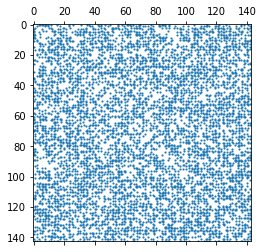

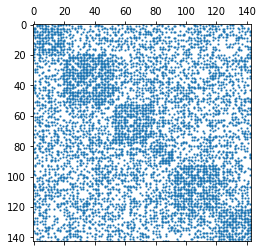

In [3]:
#Plot Adj matrix

W = data.W
plt.spy(W,precision=0.01, markersize=1)
plt.show()

idx = np.argsort(data.rand_idx) 
W = data.W
W2 = W[idx,:]
W2 = W2[:,idx]
plt.spy(W2,precision=0.01, markersize=1)
plt.show()


0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000


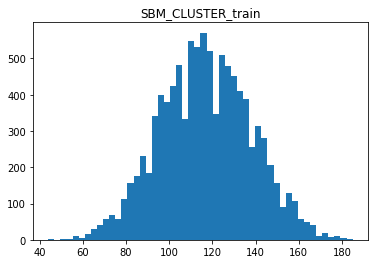

0
250
500
750
1000


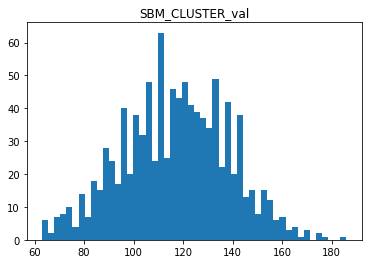

0
250
500
750
1000


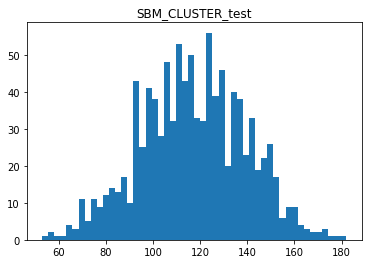

Time (sec): 132.777526140213


In [4]:
# Generate and save SBM graphs

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

def generate_semisuperclust_dataset(nb_graphs):
    dataset = []
    for i in range(nb_graphs):
        if not i%250:
            print(i)
        data = generate_SBM_graph(SBM_parameters)
        graph = DotDict()
        graph.nb_nodes = data.nb_nodes
        graph.W = data.W
        graph.rand_idx = data.rand_idx
        graph.node_feat = data.node_feat
        graph.node_label = data.node_label
        dataset.append(graph)
    return dataset

def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph.nb_nodes)
    plt.figure(1)
    plt.hist(graph_sizes, bins=50)
    plt.title(title)
    plt.show()
     
def SBMs_CLUSTER(nb_graphs, name):
    dataset = generate_semisuperclust_dataset(nb_graphs)
    print(len(dataset))
    with open(name+'.pkl',"wb") as f:
        pickle.dump(dataset,f)
    plot_histo_graphs(dataset,name)
    



start = time.time()

nb_graphs = 10000 # train
#nb_graphs = 3333 # train
#nb_graphs = 500 # train
#nb_graphs = 20 # train
SBMs_CLUSTER(nb_graphs, 'SBM_CLUSTER_train')
    
nb_graphs = 1000 # val
#nb_graphs = 333 # val
#nb_graphs = 100 # val
#nb_graphs = 5 # val
SBMs_CLUSTER(nb_graphs, 'SBM_CLUSTER_val')

    
nb_graphs = 1000 # test
#nb_graphs = 333 # test
#nb_graphs = 100 # test
#nb_graphs = 5 # test
SBMs_CLUSTER(nb_graphs, 'SBM_CLUSTER_test')

print('Time (sec):',time.time() - start) # 190s


# Convert to DGL format and save with pickle

In [5]:
import os
os.chdir('../../') # go to root folder of the project
print(os.getcwd())


/home/jrstevens/research/geometric-deep-learning/benchmarking-gnns


In [6]:

import pickle

%load_ext autoreload
%autoreload 2

from data.SBMs import SBMsDatasetDGL 

from data.data import LoadData
from torch.utils.data import DataLoader
from data.SBMs import SBMsDataset


Using backend: pytorch


In [7]:
DATASET_NAME = 'SBM_CLUSTER'
dataset = SBMsDatasetDGL(DATASET_NAME)  #3983s


[I] Loading data ...
preparing 10000 graphs for the TRAIN set...
preparing 1000 graphs for the TEST set...
preparing 1000 graphs for the VAL set...
[I] Finished loading.
[I] Data load time: 2526.9967s


In [8]:
print(len(dataset.train))
print(len(dataset.val))
print(len(dataset.test))

print(dataset.train[0])
print(dataset.val[0])
print(dataset.test[0])


10000
1000
1000
(DGLGraph(num_nodes=82, num_edges=1942,
         ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor([0, 5, 1, 2, 3, 3, 0, 1, 1, 3, 1, 3, 0, 0, 2, 0, 0, 2, 3, 3, 4, 2, 0, 1,
        5, 5, 1, 3, 3, 1, 4, 5, 5, 0, 5, 5, 1, 1, 3, 3, 3, 3, 3, 3, 2, 0, 5, 2,
        5, 0, 0, 3, 2, 4, 2, 0, 1, 1, 0, 3, 1, 2, 4, 2, 4, 3, 5, 5, 2, 0, 1, 2,
        3, 0, 0, 0, 0, 2, 1, 1, 1, 0], dtype=torch.int16))
(DGLGraph(num_nodes=112, num_edges=3894,
         ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor([4, 1, 4, 4, 2, 4, 0, 2, 5, 0, 5, 3, 2, 4, 4, 4, 0, 2, 2, 4, 1, 4, 4, 2,
        0, 0, 3, 2, 0, 0, 4, 2, 0, 5, 1, 1, 2, 0, 2, 4, 0, 0, 2, 4, 4, 4, 4, 4,
        2, 0, 0, 4, 1, 0, 2, 0, 2, 5, 5, 2, 4, 2, 2, 4, 2, 0, 0, 5, 2, 0, 3, 2,
        4, 2, 5, 2, 0, 4, 4, 4, 4, 3, 0, 4, 4, 4, 3, 1, 2, 5, 5, 4, 1, 0, 2,

In [9]:
start = time.time()

with open('data/SBMs/SBM_CLUSTER.pkl','wb') as f:
        pickle.dump([dataset.train,dataset.val,dataset.test],f)
        
print('Time (sec):',time.time() - start)


Time (sec): 7.501619815826416


# Test load function

In [10]:
DATASET_NAME = 'SBM_CLUSTER'
dataset = LoadData(DATASET_NAME) # 29s
trainset, valset, testset = dataset.train, dataset.val, dataset.test


[I] Loading dataset SBM_CLUSTER...
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 23.8555s


In [11]:
start = time.time()

batch_size = 10
collate = SBMsDataset.collate
print(SBMsDataset)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)

print('Time (sec):',time.time() - start) #0.002s


<class 'data.SBMs.SBMsDataset'>
Time (sec): 0.027278423309326172
